# Librerias

In [5]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Dataset

In [6]:
data_dir = "/Users/danielml/Documents/Computational/Curso_Bourbaki/Math_Deep_Learning/Semana_2/GroceryStoreDataset/dataset"
img_size = (180, 180)
batch_size = 32
seed = 42

In [7]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
17,Papaya,17,Papaya,10,/iconic-images-and-descriptions/Fruit/Papaya/P...,/iconic-images-and-descriptions/Fruit/Papaya/P...
77,Beef-Tomato,77,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
50,Alpro-Vanilla-Soyghurt,50,Soyghurt,25,/iconic-images-and-descriptions/Packages/Soygh...,/iconic-images-and-descriptions/Packages/Soygh...
30,God-Morgon-Apple-Juice,30,Juice,19,/iconic-images-and-descriptions/Packages/Juice...,/iconic-images-and-descriptions/Packages/Juice...
61,Cabbage,61,Cabbage,30,/iconic-images-and-descriptions/Vegetables/Cab...,/iconic-images-and-descriptions/Vegetables/Cab...


In [8]:
df_classes.shape

(81, 6)

In [9]:
df_classes.groupby(["Coarse Class ID (int)", "Coarse Class Name (str)"]).size()

Coarse Class ID (int)  Coarse Class Name (str)
0                      Apple                       5
1                      Avocado                     1
2                      Banana                      1
3                      Kiwi                        1
4                      Lemon                       1
5                      Lime                        1
6                      Mango                       1
7                      Melon                       4
8                      Nectarine                   1
9                      Orange                      1
10                     Papaya                      1
11                     Passion-Fruit               1
12                     Peach                       1
13                     Pear                        3
14                     Pineapple                   1
15                     Plum                        1
16                     Pomegranate                 1
17                     Red-Grapefruit              1

In [10]:
coarse_mapping = dict(df_classes[['Coarse Class ID (int)', 'Coarse Class Name (str)']].drop_duplicates().values)

In [11]:
filter_img = [0, 1, 2]

In [12]:
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [13]:
df_train = pd.read_csv(data_dir + "/train.txt", names = ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt", names = ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt", names = ['path','fine','coarse'])

In [14]:
df_train = df_train[df_train['coarse'].isin(filter_img)]
df_val = df_val[df_val['coarse'].isin(filter_img)]
df_test = df_test[df_test['coarse'].isin(filter_img)]

In [15]:
df_train.sample(5)

,path,fine,coarse
121,train/Fruit/Apple/Pink-Lady/Pink-Lady_018.jpg,2,0
176,train/Fruit/Apple/Red-Delicious/Red-Delicious_...,3,0
320,train/Fruit/Banana/Banana_002.jpg,6,2
55,train/Fruit/Apple/Granny-Smith/Granny-Smith_01...,1,0
310,train/Fruit/Avocado/Avocado_033.jpg,5,1


In [16]:
image = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

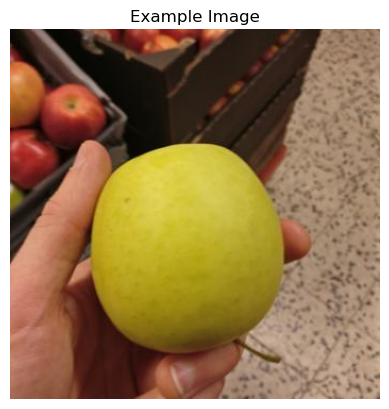

In [17]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Example Image')
plt.axis('off')
plt.show()

In [18]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

In [19]:
counts

coarse_name
Apple      278
Banana      45
Avocado     41
Name: count, dtype: int64

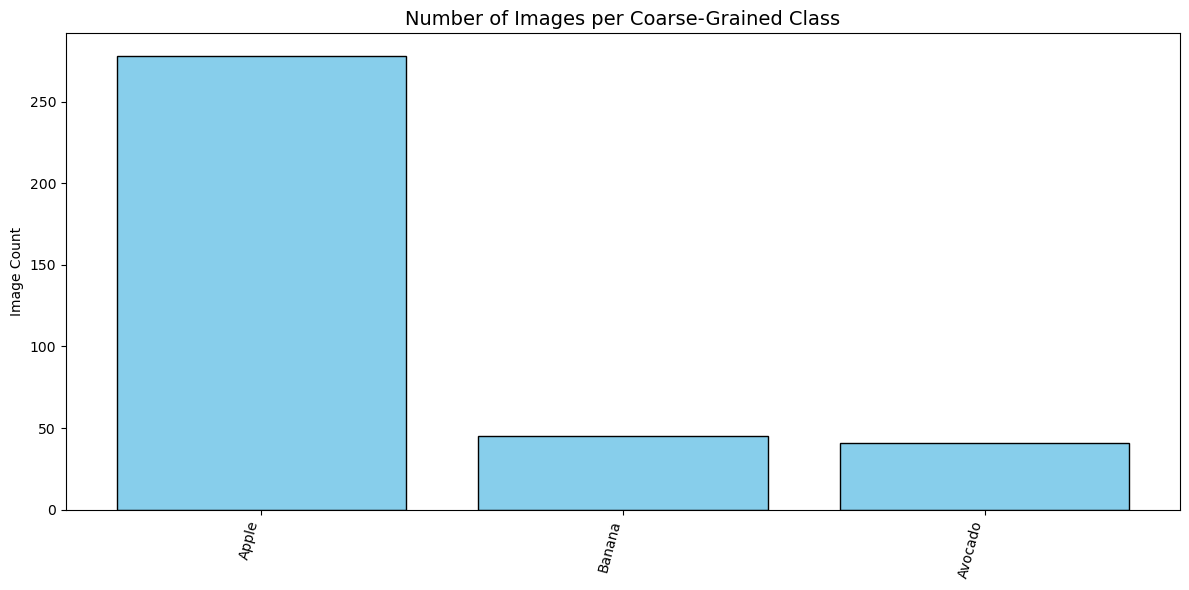

In [20]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Images per Coarse-Grained Class", fontsize=14)
plt.ylabel("Image Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# Cargar conjunto de datos con Train/ Val / Test

In [21]:
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img, img_size)
        image_ds.append(resized)
        
    image_array = np.array(image_ds)
    X = image_array / 255               # Normalizamos para que los valores de los pixeles estén en [0, 1]
    return X


In [22]:
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [23]:
X_train.shape

(364, 180, 180, 3)

In [24]:
X_val.shape

(33, 180, 180, 3)

In [25]:
X_test.shape

(360, 180, 180, 3)

In [26]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [27]:
train_counts = dict(zip(counts.index, counts.values))

In [28]:
train_counts

{'Apple': 278, 'Banana': 45, 'Avocado': 41}

## Balanceo del conjunto de datos

Distribucion de clases original
Counter({0: 278, 2: 45, 1: 41})


In [30]:
max_count = max(class_counts.values())
max_count

278

## Creamos generador de Data Augmentation

In [31]:
datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    brightness_range = [0.8, 1.2],
    fill_mode = 'nearest'
)

In [32]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [33]:
np.unique(y_train)

array([0, 1, 2])

## Oversampling dinámico

In [34]:
X_aug = []
y_aug = []

for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    X_cls = X_train[idx]
    n_current = len(X_cls)
    n_to_generate = 1500                # max_count - n_current
    
    if n_to_generate > 0:
        print(f"Clase {cls}: generando {n_to_generate} imágenes aumentadas")
        gen = datagen.flow(X_cls, batch_size = 1)
        
        for i in range(n_to_generate):
            new_img = next(gen)[0]
            X_aug.append(new_img)
            y_aug.append(cls)
    

Clase 0: generando 1500 imágenes aumentadas
Clase 1: generando 1500 imágenes aumentadas
Clase 2: generando 1500 imágenes aumentadas


## Combinamos el dataset original + aumentado 

In [38]:
if X_aug:
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    X_train_balanced = np.concatenate([X_train, X_aug], axis = 0)
    y_train_balanced = np.concatenate([y_train, y_aug], axis = 0)
    
else:
    X_train_balanced, y_train_balanced = X_train, y_train

print("\nDistribución balanceada final:")
print(Counter(y_train_balanced))


Distribución balanceada final:
Counter({0: 1778, 2: 1545, 1: 1541})


## Generamos una permutación aleatoria de indices

In [39]:
permutation = np.random.permutation(len(X_train_balanced))

# Aplicamos la permutacion a X e Y
X_train_balanced = X_train_balanced[permutation]
y_train_balanced = y_train_balanced[permutation]

In [40]:
permutation

array([ 924, 2504, 2927, ..., 2569, 2218, 3021])

# Data Augemntation

In [41]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
])

2025-12-07 21:35:07.205977: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-07 21:35:07.206270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 21:35:07.206294: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-07 21:35:07.206597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 21:35:07.207077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


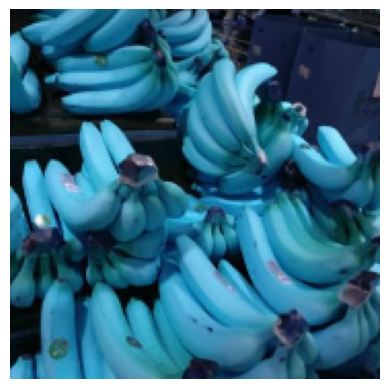

In [42]:
plt.axis('off')
plt.imshow(X_train[360])

2025-12-07 21:36:37.385068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-07 21:36:37.929419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


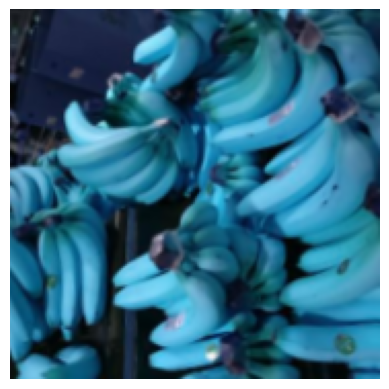

In [43]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[360])

In [44]:
num_classes = len(coarse_mapping)
num_classes

3

In [45]:
img_size + (3, )

(180, 180, 3)

# Definimos el modelo de CNN

In [46]:
model = models.Sequential([
    layers.Input(shape = img_size + (3, )),
    
    layers.Conv2D(32, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation = 'softmax')

])

# Compilamos el modelo

In [48]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = [
        'accuracy'
    ]
)

# Entrenamos el modelo

In [49]:
y_train_balanced

array([0, 1, 1, ..., 1, 1, 1])

In [50]:
num_epochs = 100

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data = (X_val, y_val),
    epochs = num_epochs,
    batch_size = 32,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
        tf.keras.callbacks.ReduceLROnPlateau(factor = 0.3, patience = 3)
    ]
)

Epoch 1/100


2025-12-07 21:56:38.936465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 16s 81ms/step - loss: 1.0843 - accuracy: 0.3746 - val_loss: 1.0139 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 2/100
152/152 [==============================] - 11s 71ms/step - loss: 1.0501 - accuracy: 0.4124 - val_loss: 0.8759 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 3/100
152/152 [==============================] - 11s 71ms/step - loss: 1.0411 - accuracy: 0.4313 - val_loss: 0.7244 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 4/100
152/152 [==============================] - 11s 70ms/step - loss: 1.0378 - accuracy: 0.4276 - val_loss: 0.5521 - val_accuracy: 0.8182 - lr: 1.0000e-05
Epoch 5/100
152/152 [==============================] - 11s 71ms/step - loss: 1.0263 - accuracy: 0.4363 - val_loss: 0.4622 - val_accuracy: 0.8182 - lr: 1.0000e-05
Epoch 6/100
152/152 [==============================] - 11s 70ms/step - loss: 1.0261 - accuracy: 0.4268 - val_loss: 0.4315 - val_accuracy: 0.8485 - lr: 1.0000e-05
Epoch 7/100
152/152 [===================

In [51]:
model.save("./models/cnn_grocery_story.h5")

/Users/danielml/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


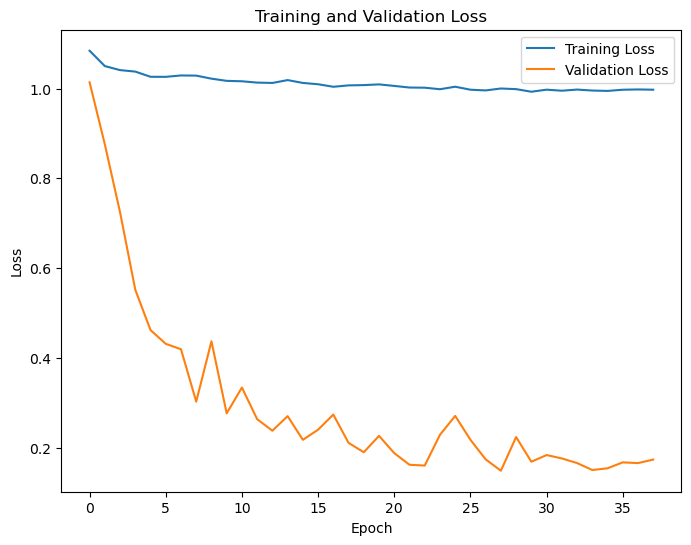

In [52]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Reporte de F1 Score y Clasificación

In [53]:
y_probs = model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

12/12 [==============================] - 1s 59ms/step


In [54]:
y_probs

array([[9.78611946e-01, 5.64027687e-06, 2.13824008e-02],
       [9.62151229e-01, 8.17654096e-03, 2.96721570e-02],
       [6.03166699e-01, 1.18290074e-04, 3.96714985e-01],
       ...,
       [1.85890645e-02, 4.39823518e-04, 9.80971158e-01],
       [7.30928421e-01, 1.60595647e-03, 2.67465621e-01],
       [8.71069014e-01, 9.51964408e-04, 1.27979010e-01]], dtype=float32)

In [55]:
y_preds

array([0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

In [56]:
f1 = f1_score(y_test, y_preds, average = 'weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.8809


In [57]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       276
           1       0.81      0.85      0.83        40
           2       0.66      0.57      0.61        44

    accuracy                           0.88       360
   macro avg       0.80      0.79      0.79       360
weighted avg       0.88      0.88      0.88       360



# Matriz de Confusión

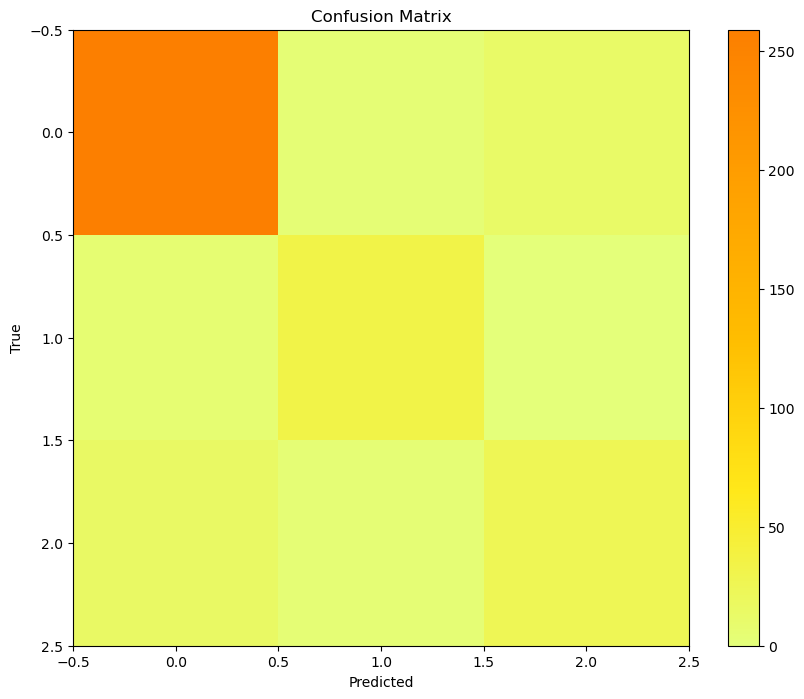

In [58]:
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Wistia')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [60]:
cm

array([[259,   4,  13],
       [  6,  34,   0],
       [ 15,   4,  25]])